# Evaluate 

In [1]:
import sys
print(sys.executable, sys.version)


import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import trimesh

from os.path import join, abspath
from IPython.display import display, HTML
from glob import glob

# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

%matplotlib inline

# for local import 
sys.path.append(abspath('..'))

from main.config import Config
from main.model import Model
from main.dataset import Dataset
from main.smpl import Smpl

from vis_util import draw_2d_on_image, show_2d_pose, show_3d_pose

/home/mmc-user/.virtualenvs/hmr2-notebook/bin/python3 3.6.8 (default, Oct  7 2019, 12:59:55) 
[GCC 8.3.0]


In [2]:
# eval_date = '02052020-143216'
# eval_date = '04052020-181359'
# eval_date = '08052020-102709' # 3d with regenerated H36M 
# eval_date = '22052020-165507' # 3d with total capture and regenerated H36M 
# eval_date = '25052020-171905' # total capture and regenerated H36M but w/ 3D groundtruth
# eval_date = '19072020-155302' # 3d with toes regressor
eval_date = '26072020-191649' # with toes regressor but w/ 3D groundtruth

class EvalConfig(Config):
    BATCH_SIZE = 64
    ENCODER_ONLY = True
    LOG_DIR = join('/', 'data', 'ssd1', 'russales', 'logs', eval_date)
    # DATA_DIR = join('/', 'data', 'ssd1', 'russales', 'tfrecords')
    DATA_DIR = join('/', 'data', 'ssd1', 'russales', 'tfrecords_with_toes')
    DATASETS = ['mpii_3d', 'h36m', 'total_cap']
    # RESTORE_PATH = join(LOG_DIR, 'ckpt-6')

# class Config is implemented as singleton, inizialize subclass first!
config = EvalConfig()

In [9]:
config.NUM_KP2D = 19
config.NUM_KP3D = 14
config.JOINT_TYPE = 'cocoplus'

In [3]:
# inizialize model 
model = Model()

Saving logs to /data/ssd1/russales/logs/26072020-191649

Configurations:
BATCH_SIZE                     64
CUSTOM_REGRESSOR_IDX           {0: 'regressor_toes_right.npy', 7: 'regressor_toes_left.npy'}
CUSTOM_REGRESSOR_PATH          /home/mmc-user/workspace/hmr2.0/models/regressors
DATASETS                       ['mpii_3d', 'h36m', 'total_cap']
DATA_DIR                       /data/ssd1/russales/tfrecords_with_toes
DISCRIMINATOR_LEARNING_RATE    0.0001
DISCRIMINATOR_LOSS_WEIGHT      1
DISCRIMINATOR_WEIGHT_DECAY     0.0001
DS_KP2D                        {'lsp': 14, 'cocoplus': 19, 'custom': 21}
DS_KP3D                        {'lsp': 14, 'cocoplus': 14, 'custom': 16}
ENCODER_INPUT_SHAPE            (224, 224, 3)
ENCODER_ONLY                   True
EPOCHS                         55
GENERATOR_2D_LOSS_WEIGHT       60.0
GENERATOR_3D_LOSS_WEIGHT       60.0
GENERATOR_LEARNING_RATE        1e-05
GENERATOR_WEIGHT_DECAY         0.0001
ITERATIONS                     3
JOINT_TYPE                     cus

### run evaluation

In [4]:
result = model.test()

initialize test dataset...
Done (t=0.25821948051452637)

Start of Testing



Time taken for testing 239.52249479293823 sec



### sort results by sequence 

In [5]:
all_kp3d_mpjpe = result['kp3d_mpjpe'].numpy()
all_kp3d_mpjpe_aligned = result['kp3d_mpjpe_aligned'].numpy()
sequences = result['seq'].numpy()

### evaluate per sequence 

In [6]:
eval_dict = {}
indices = range(len(sequences))
for i, sequence in zip(indices, sequences):
    sequence = sequence.decode("utf-8")
    if ' 2_' in sequence or ' 3_' in sequence:
        continue
    mpjpe_tuple = tuple([all_kp3d_mpjpe[i], all_kp3d_mpjpe_aligned[i]])
    if sequence not in eval_dict:
        eval_dict[sequence] = [mpjpe_tuple]
    else:
        eval_dict[sequence].append(mpjpe_tuple)

In [7]:
names, data = eval_dict.keys(), np.ndarray(shape=(len(eval_dict), 9), dtype=np.float32)

indices = range(len(names))
for i, value in zip(indices, eval_dict.values()):
    values_per_seq = np.asarray(value, dtype=np.float32)
    mpjpe = values_per_seq[:, 0, :]
    mpjpe_aligned = values_per_seq[:, 1, :]
    
    mean_mpjpe_aligned = np.mean(mpjpe_aligned)
    mean_mpjpe = np.mean(mpjpe)
    
    data[i, 0] = mean_mpjpe_aligned  # mean_error_aligned
    data[i, 1] = mean_mpjpe  # mean_error
    data[i, 2] = np.median(mpjpe)  # median_error
    data[i, 3] = np.std(mpjpe)  # standard deviation
    data[i, 4] = mpjpe.min()  # min
    data[i, 5] = mpjpe.max()  # max
    data[i, 6] = np.percentile(mpjpe, 25)  # 25 percentile
    data[i, 7] = np.percentile(mpjpe, 50)  # 50 percentile
    data[i, 8] = np.percentile(mpjpe, 75)  # 75 percentile
        
columns = ['Mean Aligned', 'Mean', 'Median', 'Standard Deviation', 'Min', 'Max', '25%', '50%', '75%']
df_seq = pd.DataFrame(data, index=names, columns=columns)

df_seq = df_seq.sort_values(df_seq.columns[0]) # sort by ascending mean aligned

display(HTML(df_seq.to_html()))

,Mean Aligned,Mean,Median,Standard Deviation,Min,Max,25%,50%,75%
h36m_sub11_Posing 1_cam58860488,59.698208,160.028824,150.611450,89.393860,17.547869,496.293976,94.272026,150.611450,211.763199
h36m_sub11_Posing_cam58860488,61.084881,158.069275,146.982666,88.007561,10.760425,490.105042,89.479355,146.982666,214.624924
h36m_sub9_Purchases 1_cam58860488,62.067066,143.644699,135.714264,80.823486,9.254466,775.753174,79.584991,135.714264,187.327271
h36m_sub11_Purchases_cam58860488,62.135029,128.186493,117.392059,65.879021,8.833021,426.162415,79.704330,117.392059,167.947525
h36m_sub11_Purchases 1_cam58860488,63.093647,127.643074,116.340866,65.835892,8.979612,525.963074,83.883568,116.340866,162.766083
h36m_sub11_Discussion 1_cam58860488,63.300003,149.578964,140.040894,83.095879,7.052701,570.146362,84.180840,140.040894,202.404800
h36m_sub9_Purchases_cam58860488,65.445473,140.011780,133.458054,69.700203,12.980973,558.753662,83.017944,133.458054,182.786407
h36m_sub11_Directions 1_cam58860488,69.771072,147.246689,143.537857,81.927673,12.843741,591.045166,74.893692,143.537857,201.755859
h36m_sub9_Directions_cam60457274,70.726723,111.534782,93.216766,84.442764,8.489927,943.969666,57.585602,93.216766,137.073517
h36m_sub11_Purchases_cam60457274,70.782188,104.441742,88.036880,62.766758,6.594195,450.167236,58.282192,88.036880,134.482498


In [8]:
df_seq.describe()

,Mean Aligned,Mean,Median,Standard Deviation,Min,Max,25%,50%,75%
count,336.000000,336.000000,336.000000,336.000000,336.000000,336.000000,336.000000,336.000000,336.000000
mean,99.786552,199.832474,157.111160,152.642456,6.305059,1140.491333,91.549652,157.111160,264.420197
std,17.628963,63.967590,48.903450,51.465942,3.607631,342.364746,29.862597,48.903450,90.386719
min,59.698208,98.094315,76.298462,62.766758,0.623599,426.162415,39.805000,76.298462,126.912621
25%,87.768616,150.349121,120.035501,112.166172,3.804783,904.698532,68.994095,120.035501,197.264542
50%,97.938644,181.244415,142.969032,143.104507,5.591041,1080.294739,81.455791,142.969032,235.362190
75%,112.115761,242.549751,187.169151,189.191498,8.147817,1429.960846,111.677069,187.169151,319.629028
max,153.779984,395.930145,332.476166,285.001617,29.994125,1861.216919,188.166656,332.476166,564.395203


### evaluate per joint

In [13]:
lsp_joints = ['ankle_r', 'knee_r', 'hip_r', 'hip_l', 'knee_l', 
             'ankle_l', 'wrist_r', 'elbow_r', 'shoulder_r', 
             'shoulder_l', 'elbow_l', 'wrist_l', 'neck', 'brain']


custom_joints = ['toes_r', 'ankle_r', 'knee_r', 'hip_r', 'hip_l', 'knee_l', 
             'ankle_l', 'toes_l', 'wrist_r', 'elbow_r', 'shoulder_r', 
             'shoulder_l', 'elbow_l', 'wrist_l', 'neck', 'brain']

joints = custom_joints if config.JOINT_TYPE == 'custom' else lsp_joints
num_joints = 16 if config.JOINT_TYPE == 'custom' else 14

data = np.ndarray(shape=(num_joints, 9), dtype=float)
for i, _ in enumerate(joints):
    data[i, 0] = np.mean(all_kp3d_mpjpe_aligned[:, i])  # mean_error_aligned
    data[i, 1] = np.mean(all_kp3d_mpjpe[:, i])  # mean_error
    data[i, 2] = np.median(all_kp3d_mpjpe[:, i])  # median_error
    data[i, 3] = np.std(all_kp3d_mpjpe[:, i])  # standard deviation
    data[i, 4] = all_kp3d_mpjpe[:, i].min()  # min
    data[i, 5] = all_kp3d_mpjpe[:, i].max()  # max
    data[i, 6] = np.percentile(all_kp3d_mpjpe[:, i], 25)  # 25 percentile
    data[i, 7] = np.percentile(all_kp3d_mpjpe[:, i], 50)  # 50 percentile
    data[i, 8] = np.percentile(all_kp3d_mpjpe[:, i], 75)  # 75 percentile
        
columns = ['Mean Aligned', 'Mean', 'Median', 'Standard Deviation', 'Min', 'Max', '25%', '50%', '75%']
df_joint = pd.DataFrame(data, index=joints, columns=columns)
df_joint = df_joint.sort_values(df_joint.columns[0])

display(HTML(df_joint.to_html()))

,Mean Aligned,Mean,Median,Standard Deviation,Min,Max,25%,50%,75%
neck,54.010696,201.694565,140.879044,170.858353,2.873360,1319.014771,84.656794,140.879044,248.810238
shoulder_r,59.403782,164.627838,128.814133,122.915291,0.623599,1225.803833,78.767780,128.814133,209.749172
shoulder_l,66.015610,243.022415,160.136932,217.724945,1.846626,1375.471680,97.796261,160.136925,296.927589
hip_l,82.346008,141.079361,92.772614,126.098938,1.570624,753.335693,57.356879,92.772614,169.019196
knee_l,85.382797,133.622208,104.356407,97.290703,1.986379,1018.453674,71.770201,104.356407,162.474144
knee_r,86.531128,75.683868,56.831486,56.917435,1.207907,432.843384,38.992396,56.831486,91.625721
elbow_l,88.117867,276.157318,181.403046,254.862823,3.025356,1514.177979,108.457321,181.403038,335.517593
hip_r,92.523552,75.683868,56.831711,56.917435,1.207953,432.843384,38.992231,56.831711,91.625647
elbow_r,95.254349,171.219162,142.132202,114.585274,1.363042,1064.544922,89.062717,142.132195,224.614754
brain,102.209778,252.775375,188.981796,199.704163,3.888459,1721.622437,108.837696,188.981796,327.551720


In [14]:
df_joint.describe()

,Mean Aligned,Mean,Median,Standard Deviation,Min,Max,25%,50%,75%
count,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000
mean,100.146708,202.435033,154.138874,152.873304,2.469318,1239.993511,98.712196,154.138872,252.039727
std,30.647066,69.091540,54.418276,60.891122,1.200953,418.993278,36.337588,54.418276,86.601855
min,54.010696,75.683868,56.831486,56.917435,0.623599,432.843384,38.992231,56.831486,91.625647
25%,84.623600,158.740719,122.699701,120.832787,1.518728,1053.022110,77.018385,122.699701,199.566678
50%,93.888950,221.814590,170.336121,150.580872,2.381416,1316.102478,103.126791,170.336117,271.688202
75%,115.043400,253.174175,188.472717,178.069805,3.360989,1515.995392,123.892698,188.472717,317.815424
max,164.495102,298.199097,234.746643,267.579895,4.663132,1861.216919,158.333889,234.746651,365.376404


### evaluate overall

In [15]:
all_mpjpe_aligned = np.mean(all_kp3d_mpjpe_aligned)
all_mpjpe = np.mean(all_kp3d_mpjpe)

print('Mean Aligned: {:.3f} --- Mean: {:.3f}'.format(all_mpjpe_aligned, all_mpjpe))
# Mean Aligned: 75.482 --- Mean: 120.937

Mean Aligned: 100.147 --- Mean: 202.435


In [16]:
percentiles = [10, 30, 50, 70, 90]
data = np.ndarray(shape=(5, 2), dtype=float)
for i, percentile in enumerate(percentiles):
    data[i, 0] = np.percentile(all_kp3d_mpjpe_aligned, percentile)
    data[i, 1] = np.percentile(all_kp3d_mpjpe, percentile)

columns = ['10%', '30%', '50%', '70%', '90%']
df_percentiles = pd.DataFrame(data.T, index=['Mean Aligned', 'Mean'], columns=columns)
df_percentiles

,10%,30%,50%,70%,90%
Mean Aligned,32.529463,56.111166,80.654068,115.000060,191.532275
Mean,48.970133,96.155823,150.268311,227.454085,425.527377


In [17]:
def eval_per_dataset(name):
    len_ds = len([k for k in eval_dict.keys() if name in k])
    data = []

    indices = range(len(eval_dict.keys()))
    for i, (key, value) in zip(indices, eval_dict.items()):
        if name not in key:
            continue

        values_per_seq = np.asarray(value, dtype=np.float32)
        mpjpe = values_per_seq[:, 0, :]
        mpjpe_aligned = values_per_seq[:, 1, :]

        mean_mpjpe_aligned = np.mean(mpjpe_aligned)
        mean_mpjpe = np.mean(mpjpe)
        
        data.append(tuple([mean_mpjpe_aligned, mean_mpjpe]))  
        
    data = np.asarray(data, dtype=float)
    return np.mean(data[:, 0]), np.mean(data[:, 1])

In [18]:
mpjpe_aligned_mpi, mpjpe_mpi = eval_per_dataset('h36m')
print('HUMAN 3.6M')
print('Mean Aligned: {:.3f} --- Mean: {:.3f}'.format(mpjpe_aligned_mpi, mpjpe_mpi))
#Mean Aligned: 69.824 --- Mean: 104.803

HUMAN 3.6M
Mean Aligned: 91.888 --- Mean: 162.868


In [19]:
mpjpe_aligned_mpi, mpjpe_mpi = eval_per_dataset('mpi')
print('MPII 3D')
print('Mean Aligned: {:.3f} --- Mean: {:.3f}'.format(mpjpe_aligned_mpi, mpjpe_mpi))
# Mean Aligned: 111.461 --- Mean: 170.702

IndexError: too many indices for array

In [20]:
mpjpe_aligned_tc, mpjpe_tc = eval_per_dataset('TC')
print('Total Capture')
print('Mean Aligned: {:.3f} --- Mean: {:.3f}'.format(mpjpe_aligned_tc, mpjpe_tc))
# Mean Aligned: 82.687 --- Mean: 145.739

Total Capture
Mean Aligned: 114.004 --- Mean: 266.369


### save to csv

In [21]:
frames = [df_seq, df_joint]

dataframes = pd.concat(frames)
dataframes.to_csv('evaluation_{}.csv'.format(eval_date))

### Visualize

### run inference and visualize

In [23]:
# example = join("/data/ssd1/russales/tfrecords/mpii_3d", "341_test.tfrecord")
example = join("/data/ssd1/russales/tfrecords_with_toes/total_cap", "305_test.tfrecord")

# load record
dataset = Dataset()
dataset = dataset.get_data_for(example).shuffle(500, seed=14)

In [34]:
# run inference
for example in dataset.take(1):
    original = example
    result = model.detect(example[0])

#### show original image with ground truth

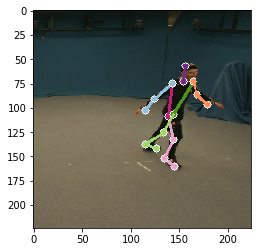

In [35]:
%matplotlib inline
image = original[0].numpy()
kp2d = original[1].numpy()[:, :2]
vis = original[1].numpy()[:, 2]

image = draw_2d_on_image(image, kp2d, vis=vis)
plt.imshow(image)
plt.show()

#### show image with predicted 2d keypoints

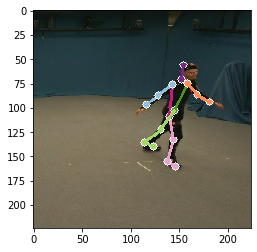

In [36]:
image = original[0].numpy()
kp2d = np.squeeze(result['kp2d'].numpy())
vis = original[1].numpy()[:, 2]
image = draw_2d_on_image(image, kp2d, vis=vis)
plt.imshow(image)
plt.show()

#### show both poses in seperate plots 

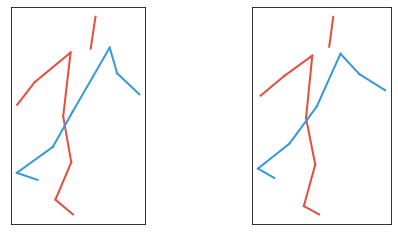

In [37]:
fig = plt.figure(figsize=plt.figaspect(0.5))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

vis = np.expand_dims(original[1].numpy()[:, 2], -1)

kp2d_real = original[1].numpy() * vis
show_2d_pose(kp2d_real, vis, ax1)

kp2d_pred = result['kp2d'].numpy() * vis
show_2d_pose(kp2d_pred, vis, ax2)

<IPython.core.display.Javascript object>


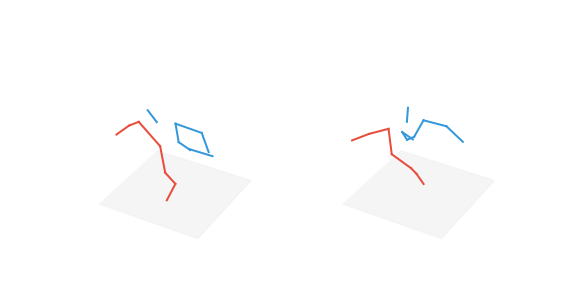

In [38]:
%matplotlib notebook
fig = plt.figure(figsize=plt.figaspect(0.5))
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax2 = fig.add_subplot(1, 2, 2, projection='3d')

# only use predicted camera
camera = np.squeeze(result['cam'].numpy())

# Plot 3d gt
kp3d_real = original[2].numpy()
show_3d_pose(kp3d_real, ax1)

# Plot 3d predictions
kp3d_pred = np.squeeze(result['kp3d'].numpy())
kp3d_pred = kp3d_pred[:config.NUM_KP3D, :] # only lsp prediction
show_3d_pose(kp3d_pred, ax2)

In [39]:
image = original[0].numpy()

vertices = np.squeeze(result['vertices'].numpy())

In [40]:
from trimesh_renderer import TrimeshRenderer
renderer = TrimeshRenderer()

mesh = renderer.mesh(vertices)
mesh.show()